# 📄 Extracting Text from Scientific Papers with Configuration

## 🔧 1. Setup

In [9]:
# Imports
import os
import pandas as pd
import sys


# Make sure Python can find your scripts folder
sys.path.append("..")

# Import the functions
from scripts.pdf_reader import extract_full_text, extract_partial_text
from scripts.rename_pdfs import rename_pdfs_in_folder
from scripts.llm_extractor import extract_title_abstract_with_llm
from scripts.config_loader import load_config

### 🗂️ Load Configuration and Define Batch

In [2]:
# Load configuration with a specific profile
# Options: 'high_quality' or 'fast_processing' or None for default
# ⬇️ Decide which profile to use
config = load_config('fast_processing')  # Change this to use different profiles

# Print out some key configuration settings
print("🔍 Processing Configuration:")
print(f"LLM Model: {config.get('llm.model')}")
print(f"Page Limit for Metadata: {config.get('pdf.extraction.page_limit_for_metadata')}")
print(f"Extract Full Text: {config.get('pdf.extraction.full_text')}\n")

# Define batch
# ⬇️ Decide which batch to use
batch_name = "first_batch"

# Define folder paths using the configuration 
pdf_folder = os.path.join(config.get("paths.data_dir"), batch_name)
output_file = os.path.join(config.get("paths.output_dir"), f"{batch_name}.csv")

print(f"📂 PDF Folder: {pdf_folder}")
print(f"📄 Output File: {output_file}")

🔍 Processing Configuration:
LLM Model: gpt-3.5-turbo
Page Limit for Metadata: 2
Extract Full Text: True

📂 PDF Folder: ../data/batches/first_batch
📄 Output File: ../outputs/first_batch.csv


#### 🖋️ Rename the PDFs

In [3]:
# Rename PDFs using the configuration and get original filename mapping
renamed_files, original_filenames_map = rename_pdfs_in_folder(pdf_folder)
print(f"🔄 Renamed {len(renamed_files)} files")

# Show sample of original to new filename mapping
print("\n📋 Sample of original filenames:")
for i, (new_name, original_name) in enumerate(list(original_filenames_map.items())[:3]):
    print(f"  {new_name} ← {original_name}")
if len(original_filenames_map) > 3:
    print(f"  ... and {len(original_filenames_map) - 3} more")

🔄 Renamed 10 files

📋 Sample of original filenames:
  paper_001.pdf ← paper_001.pdf
  paper_002.pdf ← paper_002.pdf
  paper_003.pdf ← paper_003.pdf
  ... and 7 more


#### Test Extraction on a Single PDF

In [5]:
# Test on a single PDF
if renamed_files:
    single_pdf_path = renamed_files[0]  # Use the first PDF
    
    # Get page limit from config
    page_limit = config.get("pdf.extraction.page_limit_for_metadata")
    partial_text = extract_partial_text(single_pdf_path, page_limit)
    
    # Extract title, abstract, and confidence info using the configured model
    title, abstract, confidence_info = extract_title_abstract_with_llm(partial_text)
    
    print(f"🔬 Testing extraction on: {os.path.basename(single_pdf_path)}")
    print(f"\nTitle: {title}")
    print(f"\nAbstract: {abstract[:300]}...")
    
    # Display confidence information
    print(f"\n📊 Confidence Scores:")
    print(f"  Title confidence: {confidence_info.get('title_score')}/5")
    print(f"  Abstract confidence: {confidence_info.get('abstract_score')}/5")
    print(f"  Explanation: {confidence_info.get('explanation')}")
else:
    print("❌ No PDFs found to process")

🔬 Testing extraction on: paper_001.pdf

Title: Artificial intelligence in systematic literature reviews: reduction depends on the effort required to set up the algorithm and/or query.

Abstract: We read with interest the article by Qin et al, 2021, who used machine-learning (ML)-based natural language processing (NLP) for title and abstract screening. The potential of artificial intelligence (AI) for rapid screening in systematic literature reviews (SLRs) has been discussed for many years, ...

📊 Confidence Scores:
  Title confidence: 4/5
  Abstract confidence: 4/5
  Explanation: The title and abstract were clearly identifiable based on their content and structure.


## 📜 2. Extract Text and Abstract

In [6]:
# ============= MAIN PROCESSING CELL =============
# This is the main processing cell that extracts title and abstract with confidence scores

records = []
processed_count = 0
total_files = len(renamed_files)

# Get configuration options
extract_full = config.get("pdf.extraction.full_text", True)
page_limit = config.get("pdf.extraction.page_limit_for_metadata")
model = config.get("llm.model")

for file_path in renamed_files:
    processed_count += 1
    filename = os.path.basename(file_path)
    original_filename = original_filenames_map.get(filename, "Unknown")
    
    print(f"Processing {processed_count} of {total_files}: {filename}")
    
    try:
        # Extract text based on configuration
        if extract_full:
            full_text = extract_full_text(file_path)  # entire PDF text
        else:
            full_text = ""  # Skip full text extraction if disabled in config
            
        partial_text = extract_partial_text(file_path, page_limit)

        # Extract title, abstract, and confidence scores
        title, abstract, confidence_info = extract_title_abstract_with_llm(partial_text, model)

        # Create record with dynamic fields based on config
        record = {
            "document_id": filename,
            "original_filename": original_filename,
            "title": title,
            "abstract": abstract,
            "title_confidence": confidence_info.get("title_score", 0),
            "abstract_confidence": confidence_info.get("abstract_score", 0),
            "confidence_explanation": confidence_info.get("explanation", "")
        }
        
        # Only include raw_text if full text extraction is enabled
        if extract_full:
            record["raw_text"] = full_text
            
        records.append(record)
        
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        # Add error record
        records.append({
            "document_id": filename,
            "original_filename": original_filename,
            "title": "EXTRACTION_FAILED",
            "abstract": f"Error: {str(e)}",
            "title_confidence": 0,
            "abstract_confidence": 0,
            "confidence_explanation": f"Processing error: {str(e)}"
        })

# Create DataFrame
df = pd.DataFrame(records)
print(f"\n✅ Processed {len(records)} papers successfully")
df.head()

Processing 1 of 10: paper_001.pdf
Processing 2 of 10: paper_002.pdf
Processing 3 of 10: paper_003.pdf
Processing 4 of 10: paper_004.pdf
Processing 5 of 10: paper_005.pdf
Processing 6 of 10: paper_006.pdf
Processing 7 of 10: paper_007.pdf
Processing 8 of 10: paper_008.pdf
Processing 9 of 10: paper_009.pdf
Processing 10 of 10: paper_010.pdf

✅ Processed 10 papers successfully


,document_id,original_filename,title,abstract,title_confidence,abstract_confidence,confidence_explanation,raw_text
0,paper_001.pdf,paper_001.pdf,Artificial intelligence in systematic literatu...,EXTRACTION_FAILED,4,1,The title was clearly identified from the text...,Journal of Clinical Epidemiology 138 (2021) 24...
1,paper_002.pdf,paper_002.pdf,Large language models for conducting systemati...,EXTRACTION_FAILED,4,1,The title is clearly identified at the beginni...,Journal Pre-proof\nLarge language models for c...
2,paper_003.pdf,paper_003.pdf,Automation of systematic literature reviews: A...,Systematic literature review (SLR) studies aim...,4,3,The title is clearly identified with explicit ...,InformationandSoftwareTechnology136(2021)10658...
3,paper_004.pdf,paper_004.pdf,Automating Systematic Literature Reviews with ...,Objectives: An SLR is presented focusing on te...,4,4,The title is clearly identified within the tex...,"Preprint of: Sundaram, G. and Berleant, D., Au..."
4,paper_005.pdf,paper_005.pdf,Cutting Through the Clutter: The Potential of ...,"In academic research, systematic literature re...",5,4,The title is clearly indicated at the beginnin...,Cutting Through the Clutter: The Potential of ...


## 🔍 3. Validation

Matplotlib is building the font cache; this may take a moment.




📊 VALIDATION ANALYSIS

====== VALIDATION REPORT ======
Total papers processed: 10
Average title confidence: 4.20/5.0
Average abstract confidence: 2.50/5.0
Failed title extractions: 0 (0.0%)
Failed abstract extractions: 4 (40.0%)

Validation flags:
  - title_too_short: 0 (0.0%)
  - title_too_long: 0 (0.0%)
  - abstract_too_short: 4 (40.0%)
  - title_error_pattern: 0 (0.0%)

Average validation score: 8.40/10.0

Detailed report saved to: ../outputs/validation_report_first_batch_fast_processing.html


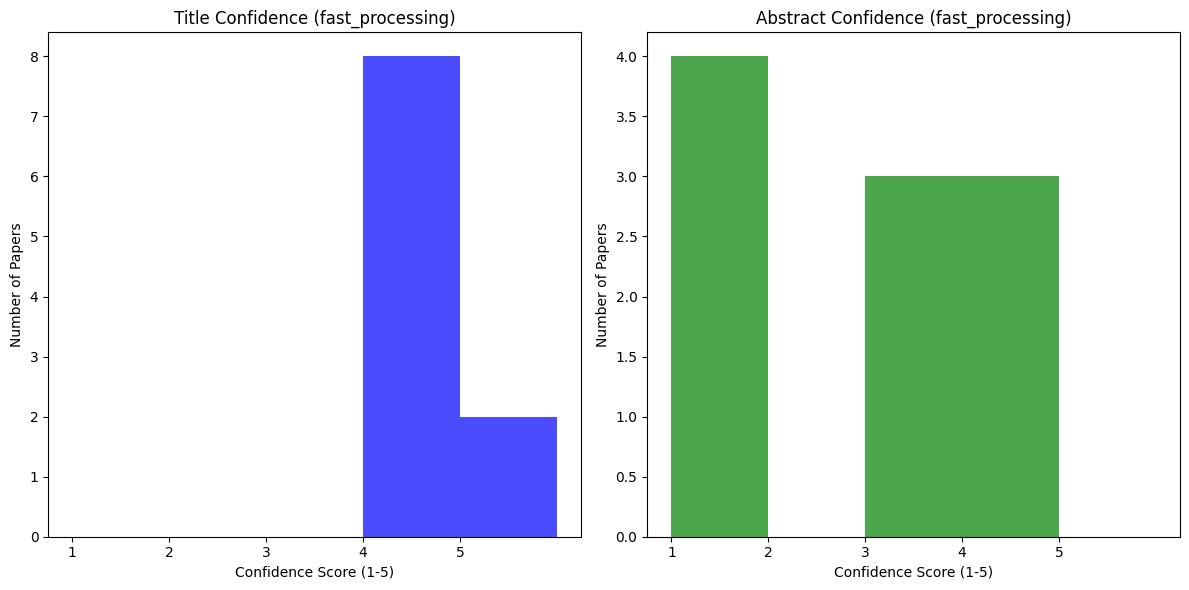


📋 Papers with low confidence scores (requiring manual review):
  - paper_001.pdf: Title confidence: 4, Abstract confidence: 1
    Explanation: The title was clearly identified from the text which discusses the use of artificial intelligence in systematic literature reviews. However, the abstract was not present in the provided text.

  - paper_002.pdf: Title confidence: 4, Abstract confidence: 1
    Explanation: The title is clearly identified at the beginning of the text. The abstract was not present in the text provided.

  - paper_006.pdf: Title confidence: 4, Abstract confidence: 1
    Explanation: The title is clearly identified with specific keywords and structure. The abstract was not directly provided in the text, so extraction failed.

  - paper_008.pdf: Title confidence: 4, Abstract confidence: 1
    Explanation: The title was clearly identified with explicit section header 'RESEARCH ARTICLE'. However, the abstract was not clearly separated and cut off in the middle of the t

In [10]:
# Import the validation utilities
from scripts.validation_utils import add_validation_flags, plot_confidence_distribution, generate_validation_report

# Generate a validation report
print("\n\n📊 VALIDATION ANALYSIS\n")
profile_name = config.get("_loaded_profile", "default")  # We'll need to add this to config_loader.py later
generate_validation_report(df, f"../outputs/validation_report_{batch_name}_{profile_name}.html")

# Plot confidence distribution
plot_confidence_distribution(df, config_name=profile_name)

# Display papers with low confidence scores
low_confidence = df[(df['title_confidence'] <= 2) | (df['abstract_confidence'] <= 2)]
if len(low_confidence) > 0:
    print("\n📋 Papers with low confidence scores (requiring manual review):")
    for _, row in low_confidence.iterrows():
        print(f"  - {row['document_id']}: Title confidence: {row['title_confidence']}, Abstract confidence: {row['abstract_confidence']}")
        print(f"    Explanation: {row['confidence_explanation']}")
        print()
else:
    print("\n✅ No papers with low confidence scores!")

## 💾 4. Export Results

In [7]:
# Get output format from config
output_format = config.get("output.format", "csv")

if output_format == "csv":
    df.to_csv(output_file, index=False)
    print(f"💾 Saved CSV to: {output_file}")
elif output_format == "json":
    json_file = output_file.replace(".csv", ".json")
    df.to_json(json_file, orient="records", indent=2)
    print(f"💾 Saved JSON to: {json_file}")
else:
    print(f"⚠️ Unsupported output format: {output_format}")

💾 Saved CSV to: ../outputs/third_batch.csv


## 📊 5. Summary Statistics

In [8]:
# Display simple statistics about the extraction
print(f"Total papers processed: {len(df)}")

# Use raw strings (r prefix) for regex patterns to avoid escape issues
print(f"Papers with title extracted: {df['title'].count() - df['title'].str.contains(r'ERROR|I dont know').sum()}")
print(f"Papers with abstract extracted: {df['abstract'].count() - df['abstract'].str.contains(r'ERROR|I dont know').sum()}")

# Calculate average lengths
avg_title_length = df['title'].str.len().mean()
avg_abstract_length = df['abstract'].str.len().mean()
print(f"Average title length: {avg_title_length:.1f} characters")
print(f"Average abstract length: {avg_abstract_length:.1f} characters")

# Show original filename mapping
print("\n🔍 Sample with original filenames:")
display(df[['document_id', 'original_filename', 'title']].head(3))

Total papers processed: 3
Papers with title extracted: 3
Papers with abstract extracted: 3
Average title length: 85.3 characters
Average abstract length: 823.3 characters

🔍 Sample with original filenames:


,document_id,original_filename,title
0,paper_001.pdf,"Technische Innovation, thereotische Sackgasse?...","Technische Innovation, theoretische Sackgasse?..."
1,paper_002.pdf,The Dynamics of Political Incivility on Twitte...,The Dynamics of Political Incivility
2,paper_003.pdf,text-as-data-the-promise-and-pitfalls-of-autom...,Text as Data: The Promise and Pitfalls of Auto...
